In [180]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.decomposition import PCA


from cryptic_rnn import *

In [181]:
# RNN params
num_classes = 22
batchsize=1
hidden_size = 20

## sequences
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
primitives = generate_pos_primitives(all_syms, cue_dict)

trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives
testseqs_all = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs_all if seq not in trainseqs_b]
val_idx = [idx for idx, seq in enumerate(testseqs_all) if seq not in trainseqs_b]

## read data 
save_dir = '../results/addition_trigrams_3inputs_bp_1000'
with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)


In [182]:
df.shape

(1000, 8)

In [184]:
full_rdmats = calculate_RDMs(res1, testseqs_all, subset = 'all')
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_b = full_rdmats['rdms_b']
dms_bp = full_rdmats['rdms_bp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

matlist = [np.array(d).mean(axis = 0) for d in dms]
matlist_p = [np.array(d).mean(axis = 0) for d in dms_p]
matlist_b = [np.array(d).mean(axis = 0) for d in dms_b]
matlist_bp = [np.array(d).mean(axis = 0) for d in dms_bp]

no. 100% trained RNNs:  1000


In [28]:
# fully trained list

ft_dms = [[dm[j] for j in ft_idx] for dm in dms]
ft_dms_p = [[dm[j] for j in ft_idx] for dm in dms_p]
ft_dms_b = [[dm[j] for j in ft_idx] for dm in dms_b]
ft_dms_bp = [[dm[j] for j in ft_idx] for dm in dms_bp]

ft_matlist = [np.array(d).mean(axis = 0) for d in ft_dms]
ft_matlist_p = [np.array(d).mean(axis = 0) for d in ft_dms_p]
ft_matlist_b = [np.array(d).mean(axis = 0) for d in ft_dms_b]
ft_matlist_bp = [np.array(d).mean(axis = 0) for d in ft_dms_bp]

# Averaged MDS

In [170]:
h=1
def calculate_RDMs_wprims(res1, testseq, num_classes=22, batchsize=1,hidden_size=20, subset = 'ft', Tmax=4):
    
    acc_df = res1['acc_df']
    if subset == 'ft':
        all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_b'] == 1)&\
                              (acc_df['acc_train_bp'] == 1) & (acc_df['acc_train_p'] == 1)].index
    elif subset == 'all':
        all_acc_mods = acc_df.index
    print('no. 100% trained RNNs: ', len(all_acc_mods))
    mod_list = all_acc_mods # choose subset of rnns 

    rdms = [] # initialise empty lists/arrays
    rdms_p = []
    rdms_b = [] # initialise empty lists/arrays
    rdms_bp = []
    # extracts res1ults from dictionary
    mods = res1['mods']
    mods_p = res1['mods_p']
    mods_b = res1['mods_b']
    mods_bp = res1['mods_bp']

    cue_dicts = res1['cue_dicts']
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 

        testseqs = change_dict(testseq, cue_dicts[m])
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=False)

        # get activations for control model
        rmat = np.empty((0, len(testseq)))
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for hid in hiddens:
            if hid.shape[0] < 4:
                rmat = np.vstack([rmat, hid[h,:]])
            else:
                rmat = np.vstack([rmat, hid[h+2,:]])
        rdms.append(euclidean_distances(rmat))
        
        rmat = np.empty((0, len(testseq)))
        hiddens, trials = get_reps(mods_p[m], [testset], hidden_size)
        for hid in hiddens:
            if hid.shape[0] < 4:
                rmat = np.vstack([rmat, hid[h,:]])
            else:
                rmat = np.vstack([rmat, hid[h+2,:]])
        rdms_p.append(euclidean_distances(rmat))  

        rmat = np.empty((0, len(testseq)))
        hiddens, trials = get_reps(mods_b[m], [testset], hidden_size)
        for hid in hiddens:
            if hid.shape[0] < 4:
                rmat = np.vstack([rmat, hid[h,:]])
            else:
                rmat = np.vstack([rmat, hid[h+2,:]])
        rdms_b.append(euclidean_distances(rmat))  
 
        rmat = np.empty((0, len(testseq)))
        hiddens, trials = get_reps(mods_bp[m], [testset], hidden_size)
        for hid in hiddens:
            if hid.shape[0] < 4:
                rmat = np.vstack([rmat, hid[h,:]])
            else:
                rmat = np.vstack([rmat, hid[h+2,:]])
        rdms_bp.append(euclidean_distances(rmat))  

        return {'rdms': rdms, 'rdms_p': rdms_p, 'rdms_b': rdms_b, 'rdms_bp': rdms_bp, 'ft_cue_dicts': ft_cue_dicts}

ca, cb, cc, cd = '#61f2c3','#48d0f2', '#3d55f9', '#7a36e4' 
ca, cb, cc, cd = 'green', 'blue', 'orange', 'red'
colors1 = [ca, cb, cc, cd]*4 + [ca, cb, cc, cd]
colors2 = [ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4 + ['black']*4

legend_elements = [Line2D([0], [0], marker=5, color='w', markerfacecolor =ca, markersize=10, label=' _ A'),
                   Line2D([0], [0], marker=5, color='w', markerfacecolor =cb,markersize=10, label=' _ B'), 
                   Line2D([0], [0], marker=5, color='w', markerfacecolor =cc, markersize=10, label=' _ C'),
                   Line2D([0], [0], marker=5, color='w', markerfacecolor =cd,markersize=10, label=' _ D'),
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=ca, markersize=10, label='A _'),
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=cb, markersize=10, label='B _'), 
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=cc, markersize=10, label='C _'),
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=cd, markersize=10, label='D _'),
                   Line2D([0], [0], marker=4, color='w', markerfacecolor='black', markersize=10, label='primitive')
                   ]


def MDS_plot(matlist, testseqs, trainseqs, MDStype = 'MDS', title = '', min_dim = 0, rand_state = 0):
    
    valset = [t for t in testseqs if t not in trainseqs]
    valset_idx = [testseqs.index(val) for val in valset]
    
    plt.rcParams['figure.figsize'] = 6, 6
    fig, axs = plt.subplots()
    for j, dist in enumerate(matlist):
        if MDStype == 'PCA':
            mds = PCA(n_components=3)
        if MDStype == 'MDS':
            mds = MDS(dissimilarity='precomputed',random_state=rand_state, n_components=3)

        X_transform = mds.fit_transform(dist)
        ax = axs
        for i in range(len(testseqs)):
            if i in valset_idx:
                alph = 1
            else:
                alph = 0.2
             
    plt.suptitle('2D-MDS'+title)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 


In [131]:
testwprims = testseqs_all + primitives
prim_rdmats = calculate_RDMs_wprims(res1, testwprims, subset = 'all')

no. 100% trained RNNs:  1000


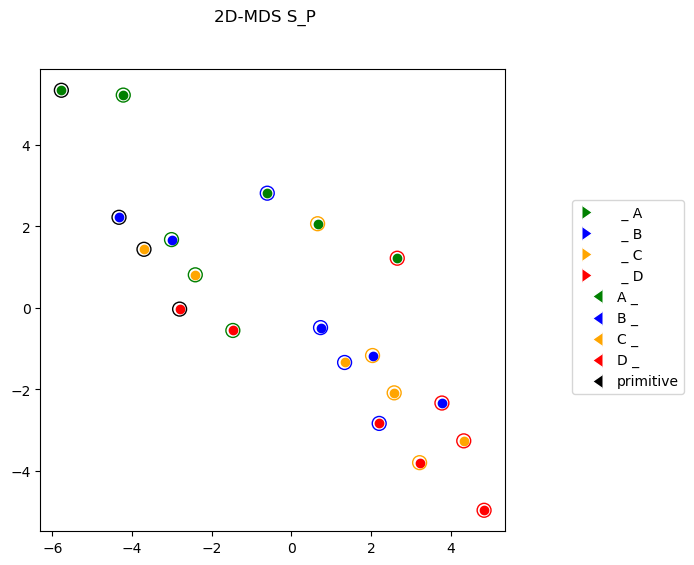

In [172]:
lp = prim_rdmats['rdms_p']
MDS_plot(lp, testwprims, [], MDStype = 'MDS', title = ' S_P')

In [145]:
cmap = plt.get_cmap('viridis', 4)

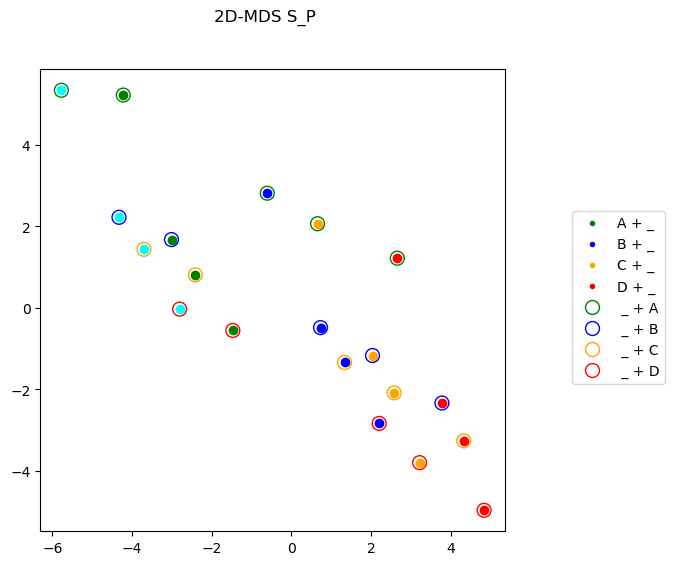

In [101]:
lp = prim_rdmats['rdms_p']
MDS_plot(lp, testwprims, [], MDStype = 'MDS', title = ' S_P')

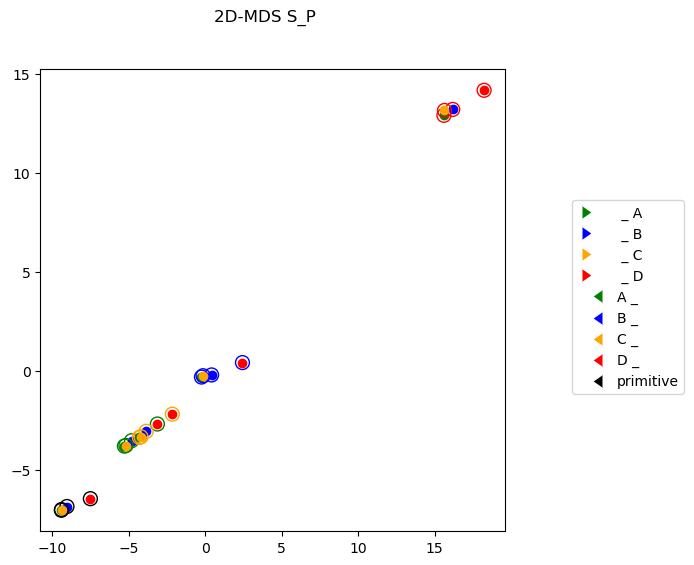

In [179]:
lp = prim_rdmats['rdms_b']
MDS_plot(lp, testwprims, [], MDStype = 'MDS', title = ' S_P')

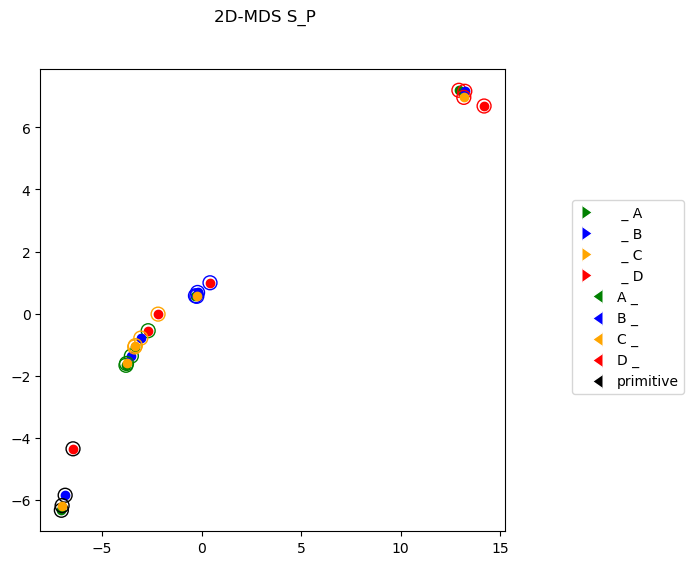

In [178]:
lp = prim_rdmats['rdms_b']
MDS_plot(lp, testwprims, [], MDStype = 'MDS', title = ' S_P', min_dim=1)

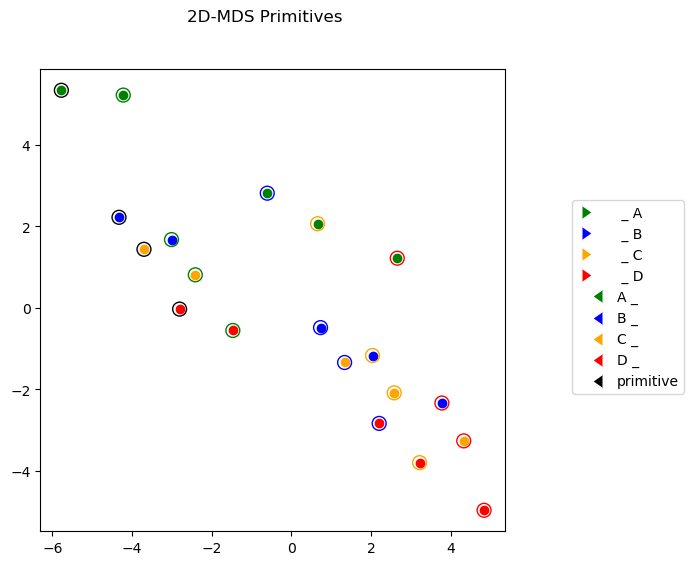

In [176]:
lp = prim_rdmats['rdms_p']
MDS_plot(lp, testwprims, [], MDStype = 'MDS', title = ' Primitives')

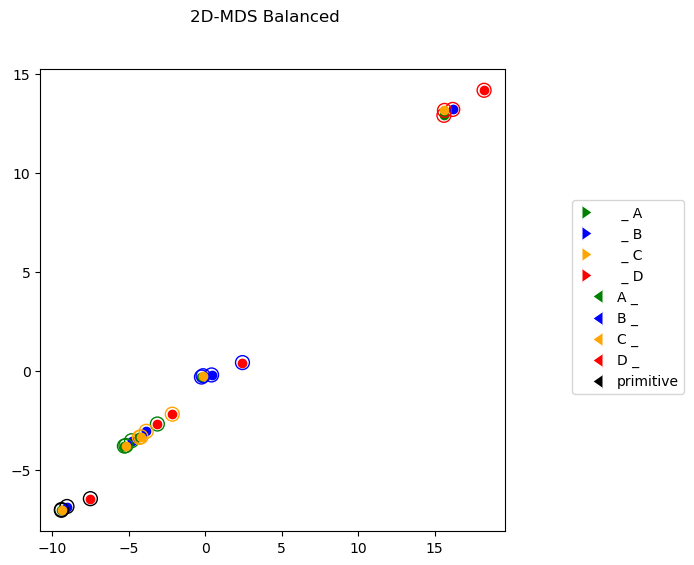

In [177]:
lp = prim_rdmats['rdms_b']
MDS_plot(lp, testwprims, [], MDStype = 'MDS', title = ' Balanced')

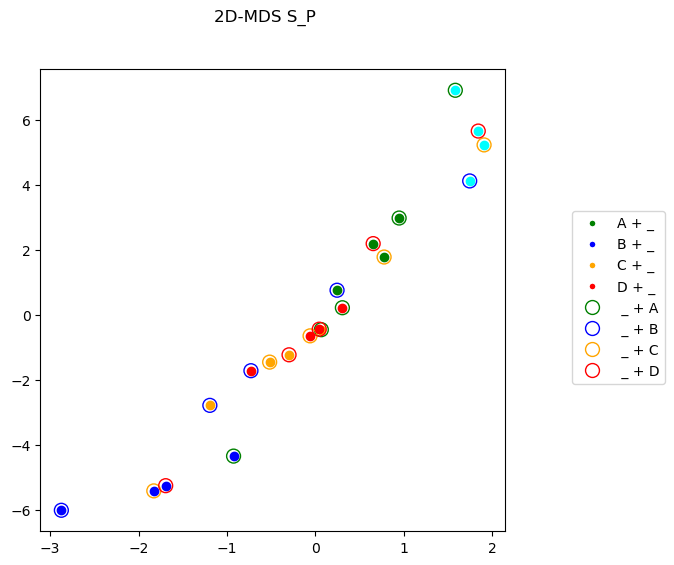

In [103]:
lp = prim_rdmats['rdms']
MDS_plot(lp, testwprims, [], MDStype = 'MDS', title = ' S_P')

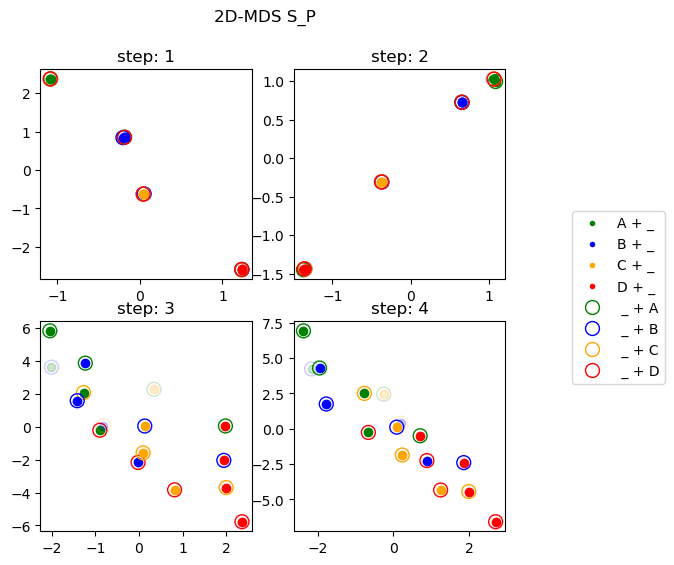

In [29]:
MDS_plot(ft_matlist_p, testseqs_all, trainseqs_p, MDStype = 'MDS', title = ' S_P', rand_state=0)

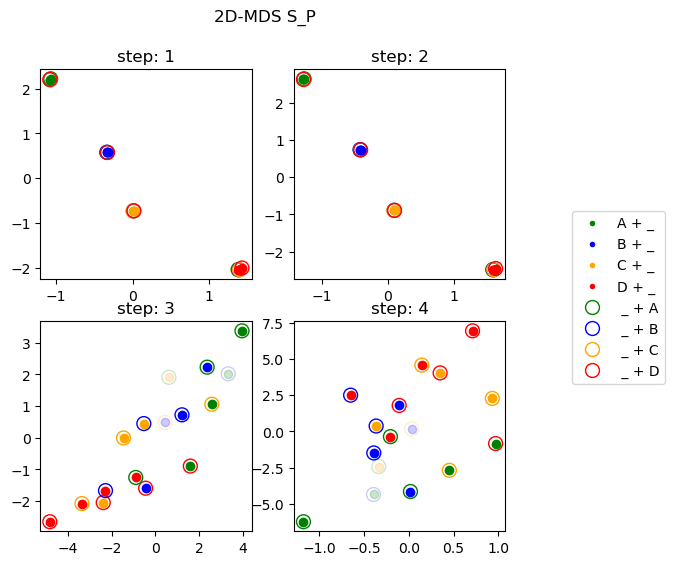

In [74]:
MDS_plot(matlist_p, testseqs_all, trainseqs_p, MDStype = 'MDS', title = ' S_P', rand_state=8)

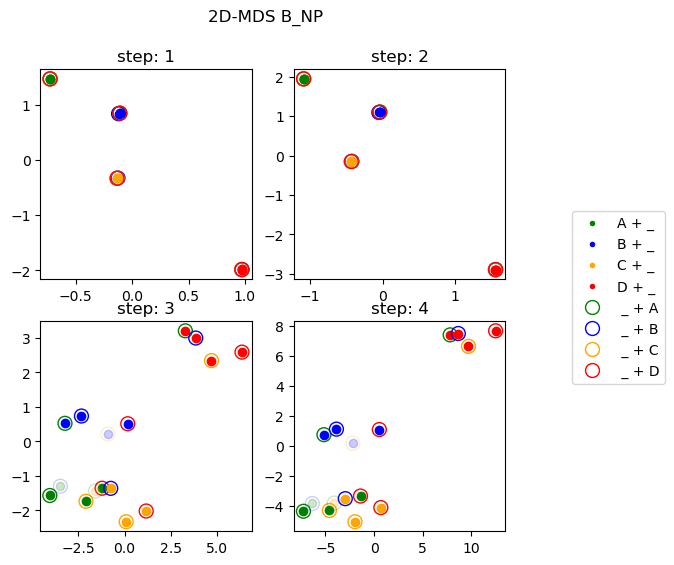

In [109]:
MDS_plot(matlist_b, testseqs_all, trainseqs_b, MDStype = 'MDS', title = ' B_NP')

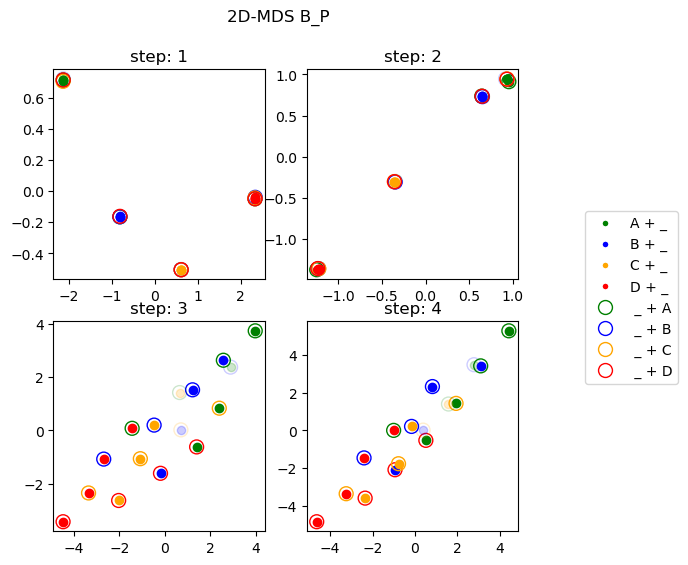

In [110]:
MDS_plot(matlist_bp, testseqs_all, trainseqs_bp, MDStype = 'MDS', title = ' B_P')

In [111]:
# Averaged PCA

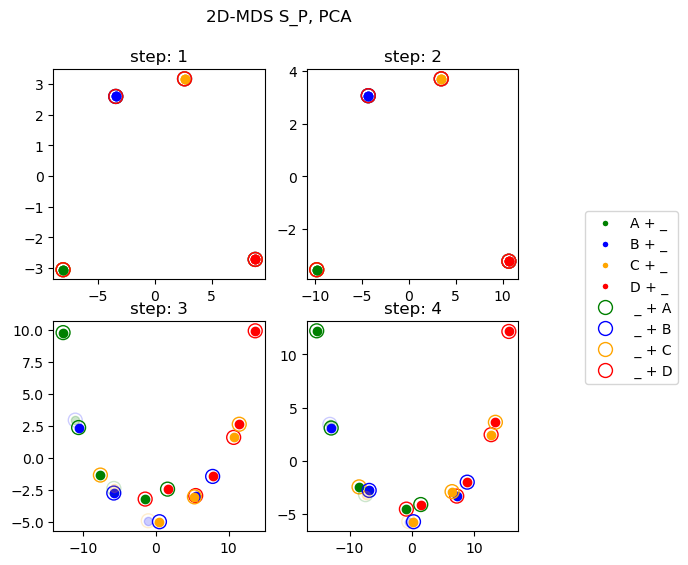

In [112]:
MDS_plot(matlist_p, testseqs_all, trainseqs_p, MDStype = 'PCA', title = ' S_P, PCA')

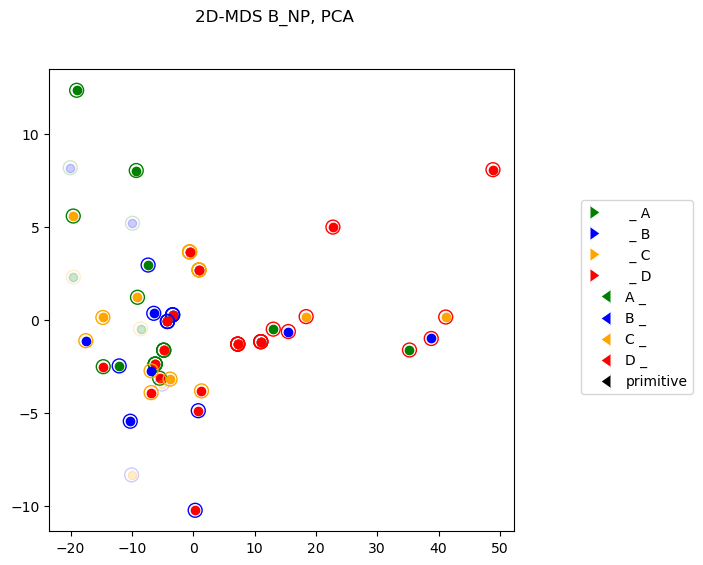

In [173]:
MDS_plot(matlist_b, testseqs_all, trainseqs_b, MDStype = 'PCA', title = ' B_NP, PCA')


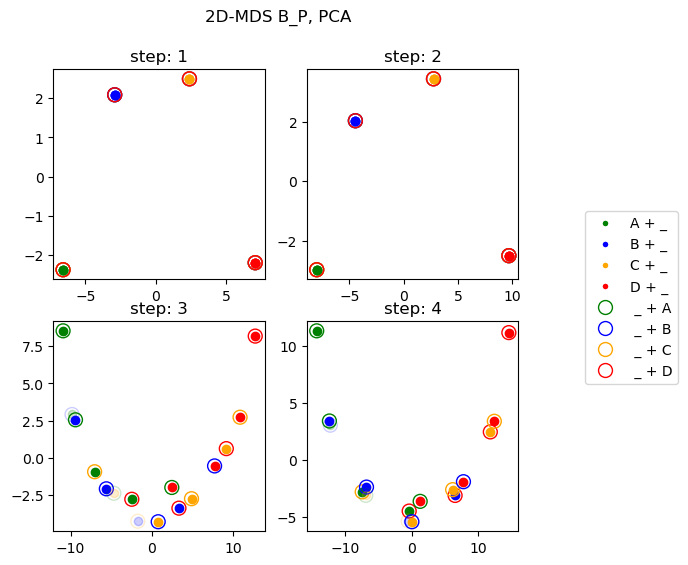

In [114]:
MDS_plot(matlist_bp, testseqs_all, trainseqs_bp, MDStype = 'PCA', title = ' B_P, PCA')


In [115]:
dm = matlist_p[2]
print(dm[0,3])
print(dm[4,7])
print(dm[8,11])
print(dm[12,15])

6.010073753588743
6.1322293133623145
6.137793466003593
6.12963289011915


In [116]:
dm = matlist_b[2]
print(dm[0,3])
print(dm[4,7])
print(dm[8,11])
print(dm[12,15])

3.987885175100374
4.048933059895174
4.049575137058937
4.047135248982578


In [117]:
t = 2
len(dms_p[t])

1000

In [118]:
#for dm in dms_p[t]:
i = 45
dm = dms_p[t][i]

In [119]:
all_dists = []
for dm in dms_p[t]:
    dists = []
    for j in range(4):
        dists.append(dm[4*j,4*j+3])
    all_dists.append(dists)
    

In [120]:
np.array(all_dists).mean()

6.102432355768445

In [121]:
all_dists_b = []
for dm in dms_b[t]:
    dists = []
    for j in range(4):
        dists.append(dm[4*j,4*j+3])
    all_dists_b.append(dists)
    

In [122]:
totdata = np.append(np.array(all_dists_b).flatten(), np.array(all_dists).flatten())
kind_data = np.repeat(['balanced', 'primitives'], len(np.array(all_dists_b).flatten()))

In [123]:
df = pd.DataFrame({'distances':totdata, 'regime':kind_data})

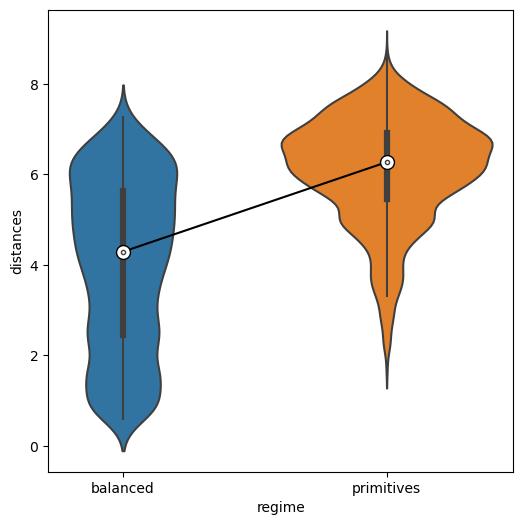

In [124]:
sns.violinplot(df, x='regime', y='distances')
median_y = [np.median(np.array(all_dists_b).flatten()),np.median(np.array(all_dists).flatten())] 
plt.plot([0,1], median_y, marker="o", markersize=10, markeredgecolor="black", markerfacecolor="white", color='black')